<a href="https://colab.research.google.com/github/Kaizer1er/DeepCropMapping/blob/master/Crops_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow

In [2]:
# Modules de traitement des données satellitaires dans l'environnement Python
import pandas as pd
import numpy as np
import glob
import os
import random as rd
from PIL import Image
import tensorflow as tf  # type: ignore
import seaborn as sns

from tensorflow.keras import Model # type: ignore
#from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D # type: ignore

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools

In [6]:
# Importation du csv
df_pickle = pd.read_csv(r"/content/Data_base2021.csv", sep=';')

# Visuel de l'organisation de la data base
df_pickle.head()

,Cultures,ID_Parcels,1,2,3,4,5,6,7,8,...,356,357,358,359,360,361,362,363,364,365
0,Blé,10890103,0.179041,0.142865,0.114165,0.092311,0.076676,0.066632,0.061550,0.060802,...,0.158151,0.176280,0.194238,0.211317,0.226808,0.240003,0.250192,0.256669,0.258724,0.255648
1,Maïs,10890255,0.138893,0.124600,0.111369,0.099169,0.087970,0.077744,0.068460,0.060090,...,0.164158,0.169893,0.176925,0.185411,0.195507,0.207369,0.221152,0.237013,0.255107,0.275591
2,Fourrage,10890258,0.179674,0.136643,0.101192,0.072763,0.050797,0.034735,0.024020,0.018093,...,0.727235,0.743082,0.755639,0.765134,0.771792,0.775841,0.777507,0.777016,0.774596,0.770473
3,Blé,10890627,0.128005,0.125288,0.122771,0.120450,0.118322,0.116384,0.114633,0.113065,...,0.195004,0.193785,0.191962,0.189505,0.186386,0.182574,0.178043,0.172761,0.166701,0.159833
4,Blé,10893218,0.169883,0.141369,0.119436,0.103511,0.093020,0.087390,0.086048,0.088422,...,0.287293,0.326865,0.367222,0.406222,0.441722,0.471580,0.493652,0.505797,0.505870,0.491731


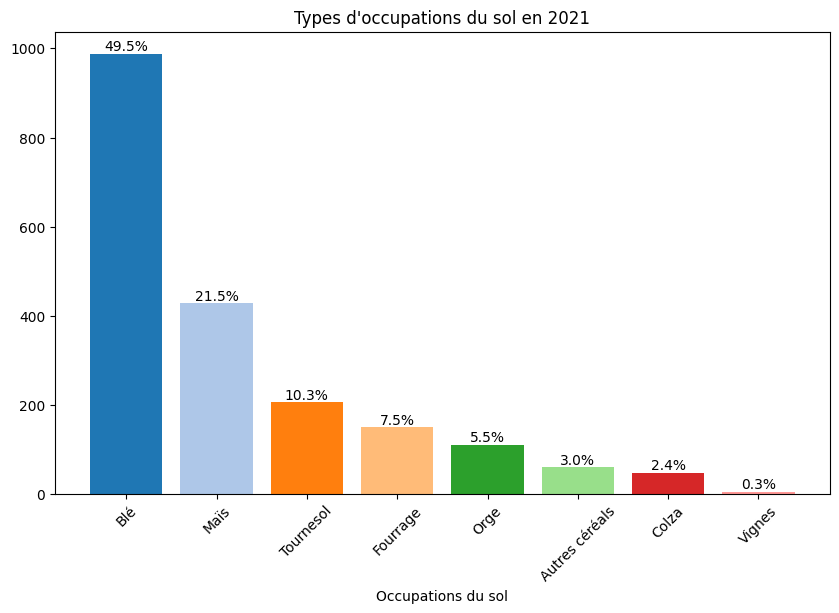

In [7]:
# Chemin complet vers le fichier CSV
Data = pd.read_csv(r"/content/Data_base2021.csv", sep=';')

# Calculer les pourcentages de chaque culture
culture_counts = Data['Cultures'].value_counts()
culture_percentages = culture_counts / culture_counts.sum() * 100

# Créer un diagramme en barres avec des couleurs distinctes
plt.figure(figsize=(10, 6))
bars = plt.bar(culture_counts.index, culture_counts, color=plt.cm.tab20.colors[:len(culture_counts)])

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars, culture_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{percentage:.1f}%',
        ha='center',
        va='bottom'
    )

# Ajouter les titres et étiquettes
plt.title("Types d'occupations du sol en 2021")
plt.xlabel('Occupations du sol')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Initialisation des encodages
label_encoder =LabelEncoder()
df_pickle['CulturesEncoded']= label_encoder.fit_transform(df_pickle['Cultures'])

df_pickle ['CulturesEncoded'].unique()

array([1, 4, 3, 6, 5, 2, 0, 7])

In [16]:
# Stratifie l'échantillonnage sur la colonne des cultures
df_tab_split = []
for cultType in df_pickle['Cultures'].unique():
    df_tab_split.append(df_pickle[df_pickle['Cultures'] == cultType])

In [17]:
# Optimisation de la taille de l'échantillon par 10 | frac 10
rdSeed = 42
for c in range(len(df_tab_split)):
    df_tab_split[c] = df_tab_split[c].sample(frac=10, random_state=rdSeed, replace=True) #shuffleling each samples per class
    print('Classe {0} -- {1} samples -- {2} %'.format('('+df_pickle['Cultures'].unique()[c]+')', len(df_tab_split[c]),  round((len(df_tab_split[c])/len(df_pickle))*100, 2)))

Classe (Blé) -- 9880 samples -- 495.49 %
Classe (Maïs) -- 4280 samples -- 214.64 %
Classe (Fourrage) -- 1500 samples -- 75.23 %
Classe (Tournesol) -- 2060 samples -- 103.31 %
Classe (Orge) -- 1100 samples -- 55.17 %
Classe (Colza) -- 470 samples -- 23.57 %
Classe (Autres céréals) -- 600 samples -- 30.09 %
Classe (Vignes) -- 50 samples -- 2.51 %


In [18]:
# Definition de la taille des train, validation et scrore csv
trainSplitPercent = 0.5
valSplitPercent = 0.3
scoreSplitPercent = 0.2

traindfs = []
valdsf = []
scoredf = []

for c in range(len(df_tab_split)):
    traindfs.append(df_tab_split[c][0:round(len(df_tab_split[c])*trainSplitPercent)])
    valdsf.append(df_tab_split[c][round(len(df_tab_split[c])*trainSplitPercent) : round(len(df_tab_split[c])*(trainSplitPercent+valSplitPercent))])
    scoredf.append(df_tab_split[c][round(len(df_tab_split[c])*(trainSplitPercent+valSplitPercent)):])

trainCSV = pd.concat(traindfs).sample(frac=1) #concat et shuffle à nouveau
valCSV = pd.concat(valdsf).sample(frac=1)
scoreCSV = pd.concat(scoredf).sample(frac=1)

print("len(trainCSV) : ", len(trainCSV))
print("len(valCSV) : ", len(valCSV))
print("len(scoreCSV) : ", len(scoreCSV))

len(trainCSV) :  9970
len(valCSV) :  5982
len(scoreCSV) :  3988


In [19]:
# Taille des échantillons train
for c in range(len(trainCSV['Cultures'].unique())):
    print('Classe {0} -- {1} samples -- {2} %'.format('('+trainCSV['Cultures'].unique()[c]+')', len(trainCSV['Cultures'][trainCSV['Cultures'] == trainCSV['Cultures'].unique()[c]]), round((100*len(trainCSV['Cultures'][trainCSV['Cultures'] == trainCSV['Cultures'].unique()[c]]))/(len(trainCSV)), 2)) )

Classe (Blé) -- 4940 samples -- 49.55 %
Classe (Maïs) -- 2140 samples -- 21.46 %
Classe (Orge) -- 550 samples -- 5.52 %
Classe (Tournesol) -- 1030 samples -- 10.33 %
Classe (Autres céréals) -- 300 samples -- 3.01 %
Classe (Fourrage) -- 750 samples -- 7.52 %
Classe (Colza) -- 235 samples -- 2.36 %
Classe (Vignes) -- 25 samples -- 0.25 %


In [20]:
# Hyper-paramètres
BATCH_SIZE = 16
NUM_EPOCHS = 100
REDUCE_LERNING_RATE = 5
EARLY_STOPPING = 10
INITIAL_LEARNING_RATE = 1e-3

In [21]:
# Initialisation de la Classe __init__ | Initialisation des attributs de l'instance et configuration du DataLoader
class ParcelleIdentificationDataLoader(tf.keras.utils.Sequence):
    def __init__(self, csvdf, batch_size, num_classes, mode='train'):
        super().__init__()

        self.csvdf = csvdf
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.timeSteps = 365

        self.mode = mode
        self.shuffle = False
        if(self.mode == 'train'):
            self.shuffle == True

        self.on_epoch_end()

# Calcul du Nombre de Batches __len__ | Retourne le nombre de lots (batch) par époque
    def __len__(self):
        bpe = int(np.ceil(len(self.csvdf)/self.batch_size))
        return bpe

# Récupération des Données par Batch __getitem__ | Récupèration des données pour un batch donné !
    def __getitem__(self, index):
        #get indexes for batch
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        x_numerical = np.full((len(idx), self.timeSteps, 1), -1.0).astype(np.float32) #[batchSize, NumberOfTimeSteps, numFeatures] #1 as only ndvi is used
        y_numerical = np.zeros((len(idx), self.num_classes)).astype(np.float32) # 11 as we have 11 output classes

        #load data
        for i, idx_val in enumerate(idx):
            df_row = self.csvdf.iloc[idx_val] #get idx_val corresponding row in dataframe

            y_numerical[i] = tf.keras.utils.to_categorical(df_row['CulturesEncoded'], num_classes=self.num_classes) #target, label

            #change nan values to -1
            df_row = df_row.replace([np.inf, -np.inf], np.nan)
            df_row = df_row.fillna(-1)

            for r in range(1, self.timeSteps): #len(dfCSV_step)
                featureValue = df_row[str(r+1)]
                x_numerical[i, r, 0] = round(featureValue, 4)

        x = x_numerical
        y = y_numerical

        if(self.mode == 'predict'):
            return (x, )
        else:
            return (x, y)

# Gestion de la Fin d'Époque on_epoch_end | Fin de chaque intération
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.csvdf))
        if(self.shuffle == True):
            np.random.shuffle(self.indexes)

In [23]:
# Définition de l'Entrée inputNumerical
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D # This line imports necessary layers
inputNumerical = Input(shape=(365, 1, ))

# Couches de Convolution conv1 et conv2
conv1 = Conv1D(32, kernel_size=3, activation='relu')(inputNumerical)
conv2 = Conv1D(32, kernel_size=3, activation='relu')(conv1)

# Aplatissement de la Sortie flat_w
flat_w = Flatten()(conv2)

# Couches de Dropout et Dense drop1 et dense1_w
drop1 = Dropout(0.1)(flat_w)
dense1_w = Dense(64, activation='relu', name='dense1_w')(drop1)

# Sortie du Modèle dense_out
dense_out= Dense(11, activation='softmax', name='dense_out')(dense1_w)

# Création et Résumé du Modèle
model = Model(inputs=inputNumerical, outputs=dense_out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 365, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 363, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 361, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1_w (Dense)                     │ (None, 64)                  │         739,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_out (Dense)                    │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 743,339 (2.84 MB)

 Trainable params: 743,339 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.SGD(learning_rate=INITIAL_LEARNING_RATE, momentum=0.9), metrics=['accuracy']) #, momentum=0.9 # loss_weights=weightloss SGD , momentum=0.7
# Si possible calculer le poids de CategoricalCrossentropy

In [25]:
# Enregistrer le modèle optimal
callback0 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./modelEddie2021.keras",
    monitor='val_loss',
    save_best_only=True
)

# Réduire le taux d'apprentissage | si le modèle ne s'améliore pas
callback1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=REDUCE_LERNING_RATE
)

# Arrêt de l'entraînement si le modèle cesse de s'améliorer
callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING
)

In [26]:
# Création des générateurs de données
train_generator = ParcelleIdentificationDataLoader(trainCSV, BATCH_SIZE, 11, mode='train')
valid_generator = ParcelleIdentificationDataLoader(valCSV, BATCH_SIZE, 11, mode='test')

In [ ]:
# Entraînement du modèle
hist = model.fit(train_generator, validation_data=valid_generator, epochs=NUM_EPOCHS, callbacks=[callback0, callback1, callback2], shuffle=False)

Epoch 1/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 106s 168ms/step - accuracy: 0.4776 - loss: 1.6654 - val_accuracy: 0.4947 - val_loss: 1.4711 - learning_rate: 0.0010
Epoch 2/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 87s 140ms/step - accuracy: 0.4965 - loss: 1.4777 - val_accuracy: 0.4941 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 3/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.4955 - loss: 1.4634 - val_accuracy: 0.4978 - val_loss: 1.4429 - learning_rate: 0.0010
Epoch 4/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 89s 143ms/step - accuracy: 0.4947 - loss: 1.4471 - val_accuracy: 0.4950 - val_loss: 1.4317 - learning_rate: 0.0010
Epoch 5/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.4937 - loss: 1.4357 - val_accuracy: 0.5020 - val_loss: 1.4241 - learning_rate: 0.0010
Epoch 6/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - accuracy: 0.4972 - loss: 1.4268 - val_accuracy: 0.5050 - val_loss: 1.4185 - learning_rate: 0.0010
Epoch 7/100
624/624 ━━━━━━━━━━━━━━━━━━━━ 85s 135ms/step - accur